## Import Libraries

In [1]:
import gym
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_ta as ta
from stockstats import StockDataFrame as Sdf
from finrl.agents.stablebaselines3.models import A2C

from finrl.agents.stablebaselines3.models import DummyVecEnv
from sklearn.preprocessing import StandardScaler

## Importing local modules

In [2]:
import os
import sys
sys.path.append('../')
from src.rl_env.stock import SingleStockEnv
from src.models.models import RLModels
from src.data.make_dataset import download_stock_data

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
TRAIN_START_DATE = '2017-08-17'
TRAIN_END_DATE = '2021-01-01'
model_list = ['ppo','a2c']
INITIAL_BALANCE = 100000
TIMESTEP =200000

### Data loading and processing

In [5]:
data_df = pd.read_csv('../data/snp.csv')[['Date','Close']].rename({'Date':'date','Close':'adjcp'}, axis = 1)

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
data_df['rsi'] = ta.rsi(data_df['adjcp'])
data_df['macd'] = ta.macd(data_df['adjcp'])['MACD_12_26_9']
data_df['macds'] = ta.macd(data_df['adjcp'])['MACDs_12_26_9']


In [8]:
data_df.fillna(0, inplace=True)

In [9]:
data_clean = data_df.copy()

In [10]:
train = data_clean[(data_clean.date>=TRAIN_START_DATE) & (data_clean.date<TRAIN_END_DATE)]
# train = data_clean[(data_clean.date>='2009-08-17') & (data_clean.date<'2020-03-29')]
# the index needs to start from 0
train=train.reset_index(drop=True)


### Training

In [11]:
model_dict = {}
for m in model_list:
    print(30*"=", m, 30*"=")
    env_train = DummyVecEnv([lambda: SingleStockEnv(train,balance = INITIAL_BALANCE, feat_list=['macd','rsi','macds'])])
    model = RLModels(m, env_train)
    model.train(total_timesteps=TIMESTEP)
    model.save(f'stock_{m}_{TIMESTEP}')
    model_dict.update({m:model})

============================== ppo ==============================
previous_total_asset:100000
end_total_asset:87555.98409644992
total_reward:-12444.015903550084
total_cost:  27111.137326501346
total trades:  925
Sharpe:  -0.2033455865477737
previous_total_asset:100000
end_total_asset:68975.35135598388
total_reward:-31024.648644016124
total_cost:  25494.617538248156
total trades:  964
Sharpe:  -0.5481033021710282
previous_total_asset:100000
end_total_asset:82191.5975728488
total_reward:-17808.402427151203
total_cost:  25310.032165300017
total trades:  924
Sharpe:  -0.2500485983557577
previous_total_asset:100000
end_total_asset:68575.06590531243
total_reward:-31424.934094687575
total_cost:  20751.91025019439
total trades:  916
Sharpe:  -0.6286479011598362
previous_total_asset:100000
end_total_asset:57583.83563209095
total_reward:-42416.16436790905
total_cost:  22007.86077822014
total trades:  1001
Sharpe:  -0.8339399018084012
previous_total_asset:100000
end_total_asset:64465.11241693003


### Testing

In [12]:
test = data_clean[(data_clean.date>=TRAIN_END_DATE) ]
# the index needs to start from 0
test=test.reset_index(drop=True)

In [13]:
def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value

### Calculating cumulative reward

In [14]:
cum_return = {}
for m in model_list:
    model = model_dict[m]
    env_test = DummyVecEnv([lambda: SingleStockEnv(test,balance = INITIAL_BALANCE,feat_list=['macd','rsi','macds'])])
    obs_test = env_test.reset()
    print("==============Model Prediction===========")
    for i in range(len(test.index.unique())):
        
        action, _states = model.predict(obs_test)
        obs_test, rewards, dones, info = env_test.step(action)
        env_test.render()
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    cum_return.update({m: (df_total_value.account_value.pct_change(1)+1).cumprod()-1})

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:111408.8944299785
total_reward:11408.894429978507
total_cost:  1068.050948987713
total trades:  815
Sharpe:  0.29374155968331533
annual return:  4.596510787024832
==============Model Prediction===========
previous_total_asset:100000
end_total_asset:106967.58218
total_reward:6967.582179999998
total_cost:  97.65782000000002
total trades:  819
Sharpe:  0.21093610228093326
annual return:  3.3391876782490115


### Plotting reward graph

In [15]:
test['date'] = pd.to_datetime(test['date'])

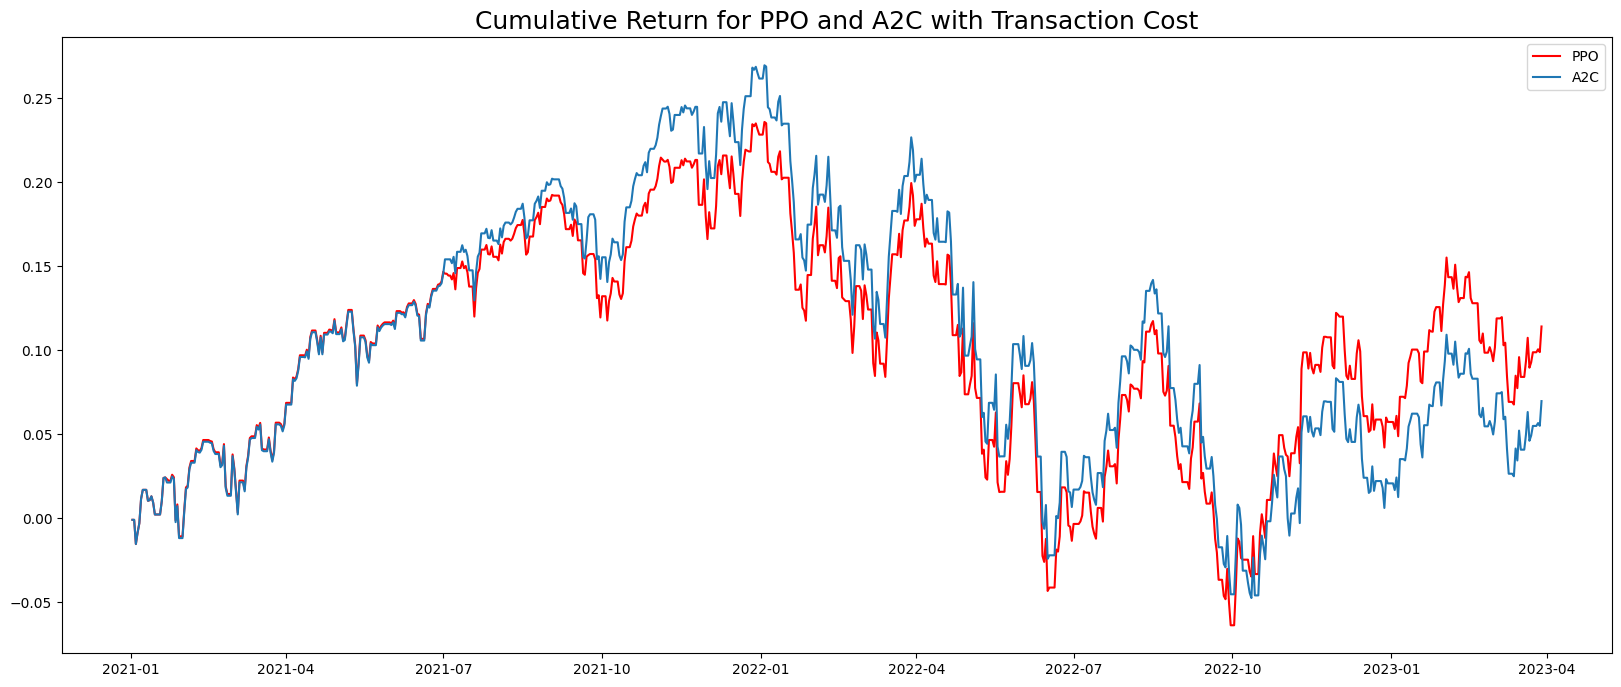

In [16]:

%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 8))

plt.plot(test.date, cum_return['ppo'], color='red',label = "PPO")
plt.plot(test.date, cum_return['a2c'], label = "A2C")
# plt.plot(test.date, cum_return['ddpg'], color = 'green', label = "DDPG")

plt.title("Cumulative Return for PPO and A2C with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
# plt.gca().xaxis.set_tick_params(rotation = 30, labelsize=3,)
plt.locator_params(axis='x', nbins=1)

## With correlation

In [17]:
bit_cor_df = pd.read_csv('../data/SnP_bit_corr.csv', usecols=['Date','Close', 'correlation']).rename({'Date':'date','Close':'bit_close', 'correlation':'cor_bit'}, axis = 1)

In [18]:
eth_cor_df = pd.read_csv('../data/SnP_eth_corr.csv', usecols=['Date','Close', 'correlation']).rename({'Date':'date', 'Close':'eth_close', 'correlation':'cor_eth'}, axis = 1)

In [19]:
df_corr = pd.concat([data_clean, bit_cor_df[['cor_bit','bit_close']],eth_cor_df[['cor_eth','eth_close']]], axis = 1).dropna()

In [20]:
train = df_corr[(data_clean.date>=TRAIN_START_DATE) & (df_corr.date<TRAIN_END_DATE)]
# the index needs to start from 0
train=train.reset_index(drop=True)


In [21]:
model_dict = {}
for m in model_list:
    print(30*"=", m, 30*"=")
    env_train = DummyVecEnv([lambda: SingleStockEnv(train,balance = INITIAL_BALANCE, feat_list=['macd','rsi','macds', 'cor_bit','cor_eth'])])
    model = RLModels(m, env_train)
    model.train(total_timesteps=TIMESTEP)
    model.save(f'stock_corr_{m}_{TIMESTEP}')
    model_dict.update({m:model})

============================== ppo ==============================
previous_total_asset:100000
end_total_asset:69349.53440443992
total_reward:-30650.465595560076
total_cost:  24629.29701594155
total trades:  966
Sharpe:  -0.48878871315659667
previous_total_asset:100000
end_total_asset:92092.71789025869
total_reward:-7907.282109741311
total_cost:  26068.625145544567
total trades:  917
Sharpe:  -0.0747823370896064
previous_total_asset:100000
end_total_asset:78221.9445737066
total_reward:-21778.055426293402
total_cost:  22874.467312902456
total trades:  878
Sharpe:  -0.4182837236256488
previous_total_asset:100000
end_total_asset:84133.8430519813
total_reward:-15866.156948018703
total_cost:  23178.071069439793
total trades:  931
Sharpe:  -0.24090107648864625
previous_total_asset:100000
end_total_asset:67577.35011210677
total_reward:-32422.649887893233
total_cost:  22243.963875824407
total trades:  918
Sharpe:  -0.7165669472565892
previous_total_asset:100000
end_total_asset:75854.12177847329

In [22]:
test = df_corr[(df_corr.date>=TRAIN_END_DATE) ]
# the index needs to start from 0
test=test.reset_index(drop=True)

In [23]:
cum_return = {}
for m in model_list:
    model = model_dict[m]
    env_test = DummyVecEnv([lambda: SingleStockEnv(test, balance = INITIAL_BALANCE, feat_list=['macd','rsi','macds','cor_bit','cor_eth'])])
    obs_test = env_test.reset()
    print("==============Model Prediction===========")
    for i in range(len(test.index.unique())):
        
        action, _states = model.predict(obs_test)
        obs_test, rewards, dones, info = env_test.step(action)
        env_test.render()
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    
    cum_return.update({m: (df_total_value.account_value.pct_change(1)+1).cumprod()-1})

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:98125.57908599814
total_reward:-1874.4209140018647
total_cost:  1671.8840961408187
total trades:  802
Sharpe:  0.04000343271635226
annual return:  0.6231273094792655
==============Model Prediction===========
previous_total_asset:100000
end_total_asset:105490.26217999999
total_reward:5490.262179999991
total_cost:  97.65782000000002
total trades:  816
Sharpe:  0.18382774844136573
annual return:  2.905655958475628


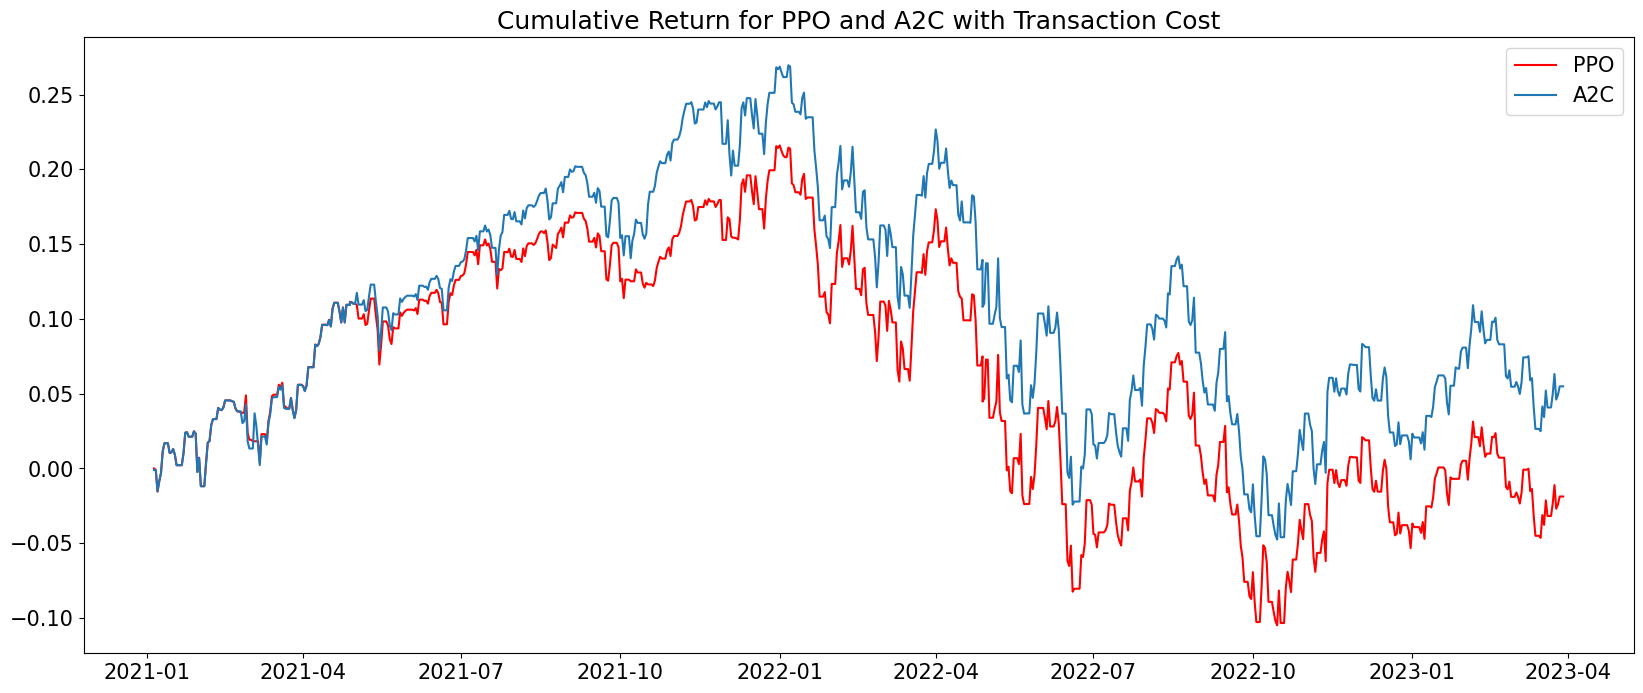

In [24]:
test = data_clean[(data_clean.date>=TRAIN_END_DATE) ][3:]
test['date'] = pd.to_datetime(test['date'])

# the index needs to start from 0

test=test.reset_index(drop=True)
%matplotlib inline
fig, ax = plt.subplots(figsize=(20, 8))

plt.plot(test.date, cum_return['ppo'], color='red',label = "PPO")
plt.plot(test.date, cum_return['a2c'], label = "A2C")
# plt.plot(test.date, cum_return['ddpg'], color = 'green', label = "DDPG")

plt.title("Cumulative Return for PPO and A2C with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
# plt.gca().xaxis.set_tick_params(rotation = 30, labelsize=3,)
plt.locator_params(axis='x', nbins=1)